In [2]:
# Rainfall using Keras
# https://www.kaggle.com/code/onya31/rainfall-using-keras/edit

# venv環境を使用

# for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for model making
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras import callbacks

# others
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/sample_submission.csv')

In [4]:
test_df['winddirection']=test_df['winddirection'].fillna(test_df['winddirection'].median())

In [ ]:
#データ可視化
cols=train_df.columns
cols=cols.drop(['rainfall'])
for i in cols:
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=train_df, y=i, x='rainfall')
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=train_df, x=i, hue='rainfall')
    plt.show()

In [ ]:
pair=train_df[['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'rainfall']]
plt.figure(figsize=(10,10))
sns.pairplot(pair, hue='rainfall', corner=True)
plt.show()

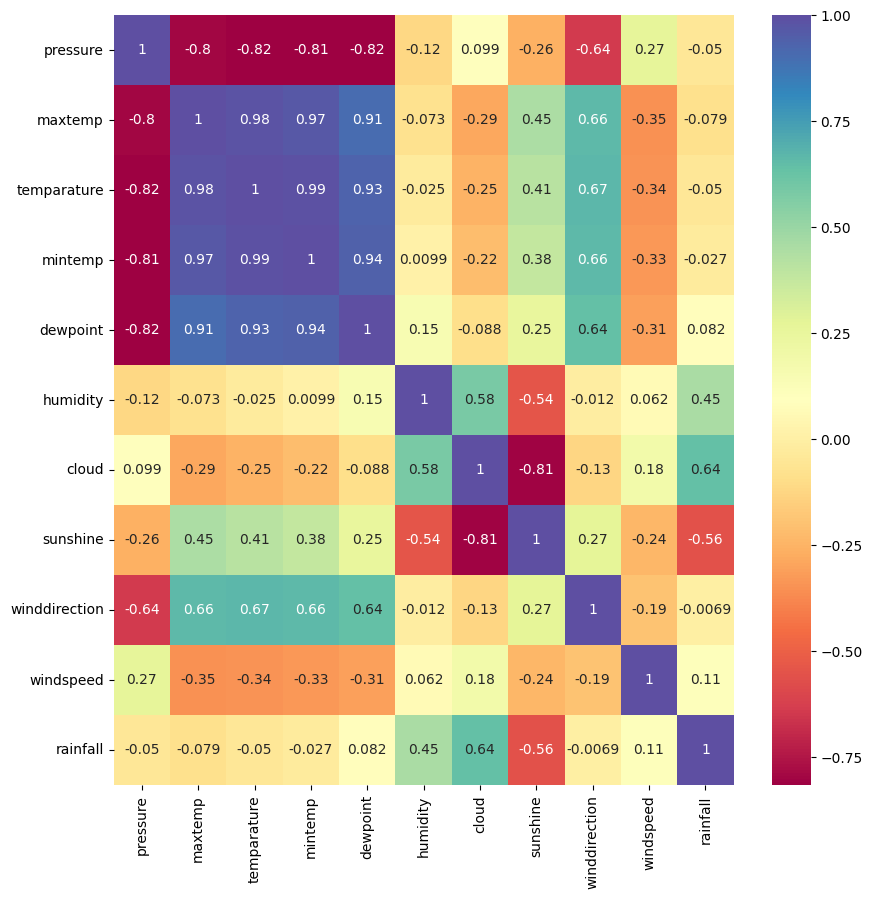

In [8]:
corr=pair.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, cmap='Spectral', annot=True)
plt.show()

In [10]:
# モデリング
x_train=train_df.drop(columns=['id','day', 'rainfall'])
x_test=test_df.drop(columns=['id','day'])
y_train=train_df['rainfall']

s=StandardScaler()
x_train[x_train.columns]=s.fit_transform(x_train[x_train.columns])
x_test[x_test.columns]=s.fit_transform(x_test[x_test.columns])

model=keras.Sequential([
    layers.BatchNormalization(input_shape=[10]),
    layers.Dense(256, kernel_initializer='he_normal'),
    layers.LeakyReLU(alpha=0.01),
    layers.Dropout(0.4),

    layers.Dense(128, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.01),

    layers.Dense(64, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.01),
    layers.Dropout(0.3),

    layers.Dense(32, kernel_initializer='he_normal'),
    layers.LeakyReLU(alpha=0.01),
    layers.Dense(1, activation='sigmoid')
])

early_stopping=callbacks.EarlyStopping(
    min_delta=0.001,
    patience=30,
    restore_best_weights=True
)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history=model.fit(
    x_train,
    y_train,
    batch_size=150,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

history_df=pd.DataFrame(history.history)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5397 - loss: 0.8076 - val_accuracy: 0.8128 - val_loss: 0.4986
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8343 - loss: 0.4234 - val_accuracy: 0.8288 - val_loss: 0.4537
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8441 - loss: 0.3743 - val_accuracy: 0.8425 - val_loss: 0.4383
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8498 - loss: 0.3744 - val_accuracy: 0.8493 - val_loss: 0.4223
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8417 - loss: 0.3897 - val_accuracy: 0.8493 - val_loss: 0.4035
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8685 - loss: 0.3598 - val_accuracy: 0.8676 - val_loss: 0.3799
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8735 - loss: 0.3394 - val_accuracy: 0.8653 - val_loss: 0.3685
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8623 - loss: 0.3425 - val_accuracy: 0.8676 - val_loss

<Axes: title={'center': 'Accuracy'}>

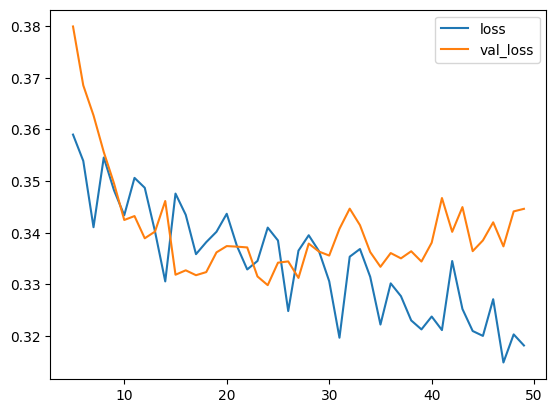

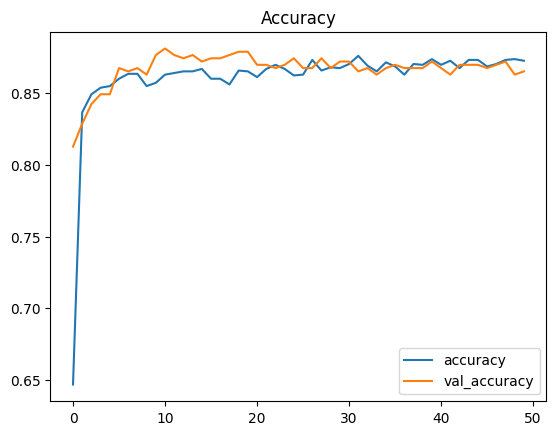

In [12]:
# 評価
history_df.loc[5:,['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [13]:
predictions=model.predict(x_test).flatten()
submission_df['rainfall']=predictions
submission_df.head()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,id,rainfall
0,2190,0.998764
1,2191,0.999540
2,2192,0.968659
3,2193,0.101082
4,2194,0.043995


In [14]:
submission_df.to_csv('./output_m2/submission.csv', index=False)